In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook


# create a small map from the original

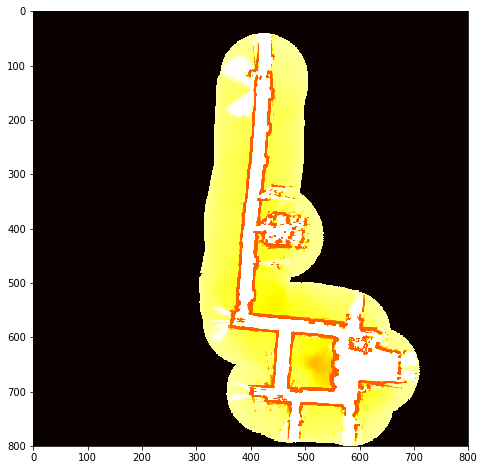

In [2]:
gmap = np.genfromtxt("data/map/wean.dat.gz", delimiter=' ', skip_header=7)
pmap = gmap[650:730, 400:500]
plt.figure(figsize=(8, 8))
plt.imshow(gmap,cmap=plt.cm.hot)

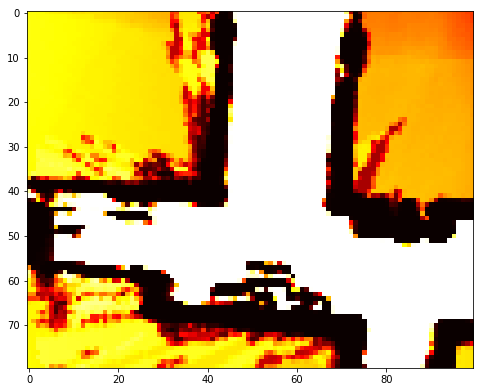

In [3]:
plt.figure(figsize=(8, 8))

plt.imshow(pmap,cmap=plt.cm.hot)


# pre-calcuate the bin file from the small map

In [4]:
import line_algorithm as line
import math


#set boundary
MAX_Y = 80
MAX_X = 100
MAX_STEPS = 120
HI_SPACE_THRESHOLD = 0.9 # it's a empty sapce if higher than this value
LO_WALL_THRESHOLD = 0.2 # it's a wall (or barrier) if lower than this value

values = np.full((MAX_Y,MAX_X,MAX_STEPS),-1.0)

#functions
def get_distance(x1,y1,x2,y2): #distance formula
    distance = ((x1-x2)**2 +(y1-y2)**2)**0.5
    return distance

def bresenham(x1,y1,x2,y2): #get points in a line between points
    if x1==None or y1==None or x2==None or y2==None:
        return
    else:
        l = line.bresenham([x1,y1],[x2,y2])
        return l
    

def get_boy_cord(degree,x1,y1): #gets x2 and y2, works for x not = 0
    if x1==0 or x1== MAX_Y-1 or y1 == 0 or y1 == MAX_X-1:
        return None,None
    alpha = math.radians(degree)
    side = get_side(alpha,x1,y1)
    #print(str(alpha) + " :this is the angle")
    #print(str(side) + ": this is the side")
    #print(str(get_corner_angles(x1,y1))+": these are my angles")
    if side==1:
        length = MAX_Y-1 - x1 #adjacent side
        height = int(round(length*math.tan(alpha),0)) # gets the opposite side
        x2,y2=MAX_Y-1,y1+height
        return x2,y2
    elif side==2:
        height = MAX_X-1 - y1
        length = int(round(height/math.tan(alpha),0))
        x2,y2 = x1+length, MAX_X-1
        return x2, y2
    elif side==3:
        length = -x1
        height = int(round(length*math.tan(alpha),0))
        x2, y2 = 0, y1 + height
        return x2, y2
    elif side==4:
        height = -y1
        length = int(round(height/math.tan(alpha),0))
        x2, y2 = x1 + length, 0
        return x2,y2

def get_side(angle,x,y): #check which side we are hitting, angle in radians
    alpha = angle
    #quadrants = get_corner_angles(x,y)
    #check which side will the angle end in
    if alpha > corner_angles[0] and alpha <= corner_angles[1]: # side2
        return 2
    elif alpha > corner_angles[1] and alpha <= corner_angles[2]: #side3
        return 3
    elif alpha > corner_angles[2] and alpha <= corner_angles[3]: #side4
        return 4
    else:
        return 1
def get_corner_angles(x,y): # gets the angles to hit the corners
    # note, arctan range is -pi/2 to pi/2
    angles = []
    # quadrant I
    length,height = MAX_Y-1 - x, MAX_X-1-y
    theta = math.atan(height/length)
    angles.append(theta)
    # quadrant II: gets a negative IV, so we + pi
    length,height = -x, MAX_X-1-y
    theta = math.atan(height/length)
    angles.append(theta + math.pi)
    #quadrant III: gets 1st quadrant, so we + pi
    length,height = -x,-y
    theta = math.atan(height/length)
    angles.append(theta+math.pi)
    #quadrant IV: gets negative IV, so we +2pi 
    length,height = MAX_Y-1- x,-y
    theta = math.atan(height/length)
    angles.append(theta + 2*math.pi)
    return angles


#create numpy array, 3-D, each 2D coordinate has 120 values
print("started to create the measured-range-bin")

#for each x,y value
for y_cord in range(MAX_Y):
    for x_cord in range(MAX_X):
        #print("progress X:"+str(y_cord) + " Y:" + str(x_cord))

        #for each line with a slope of a 3 degree interval (0-357)
        if y_cord==0 or y_cord== MAX_Y-1 or x_cord == 0 or x_cord == MAX_X-1:
            continue

        # check the current position map value (cmv)
        # skip if the current area is not in empty space
        cmv = pmap[y_cord,x_cord]
        if  not cmv >= HI_SPACE_THRESHOLD:
            continue
        
        corner_angles = get_corner_angles(y_cord,x_cord)
        for slope in range(MAX_STEPS):

            #print("progress:"+str(y_cord)+" "+str(x_cord)+" "+str(slope))
            #find the start and end of the line (coordinate point to edge)
            x2,y2 = get_boy_cord(slope*3,y_cord,x_cord)
            #plug into bresenham to get points
            l = bresenham(y_cord,x_cord,x2,y2)
            #check each coordinate of bresenhams
            if l == None:
                continue
            for tuple_value in l.path:
                pmap_value = pmap[tuple_value[0], tuple_value[1]]
                #if wall is hit calculate distance (point to wall)
                if pmap_value <= LO_WALL_THRESHOLD:
                    d = get_distance(y_cord,x_cord,tuple_value[0],tuple_value[1])
                    values[y_cord,x_cord,slope] = d
                    break

print("Finished to create the measured-range-bin")


started to create the measured-range-bin
Finished to create the measured-range-bin


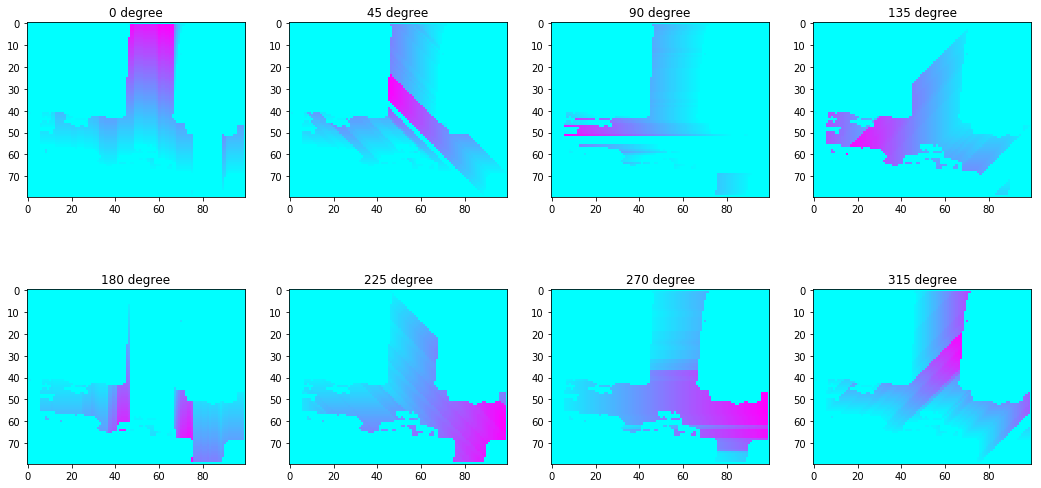

In [40]:
# show the range-estimation of 0, 45, 90, 135, 180, 225, 270, 315
# 3 degree per step. 
# id is 0, 15, 30, 45, 60, 75, 90, 105
#


plt.figure(figsize=(18, 9))


for i in range(8):
    thisStep = i*15
    plt.subplot(2,4,i+1)
    plt.imshow(values[:,:,thisStep],cmap=plt.cm.cool)
    plt.title(str(thisStep*3)+" degree")
